#Transfer-Learning-with-Fast.ai-and-Pytorch-equivalent

## Run the code: To train and run the model, you should gather your own dataset and label it as I did in the csv file 'labels.csv'. Then just replace the 'path' variable with your own, and voila!

## Classification of face beauty, according to me

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

<font size="5">
    In this notebook I present the fast.ai library ease of use, and then show an equivalent using only pytorch
</font> 

#Using fastai

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
path = './drive/My Drive/AI_Perso/'

##Dataset and dataset transformations,  split training/validation


In [0]:
# creating dataset
data = ImageDataBunch.from_csv(path=path, folder='img', csv_labels='labels.csv', ds_tfms=get_transforms(), size=(218, 178))

In [0]:
# show source code
data = ImageDataBunch.from_csv??

In [0]:
print(imagenet_stats)

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


In [0]:
# normalisation
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (408 items)
x: ImageList
Image (3, 218, 178),Image (3, 218, 178),Image (3, 218, 178),Image (3, 218, 178),Image (3, 218, 178)
y: CategoryList
belle,belle,belle,belle,belle
Path: drive/My Drive/AI_Perso;

Valid: LabelList (102 items)
x: ImageList
Image (3, 218, 178),Image (3, 218, 178),Image (3, 218, 178),Image (3, 218, 178),Image (3, 218, 178)
y: CategoryList
pas_belle,belle,pas_belle,pas_belle,pas_belle
Path: drive/My Drive/AI_Perso;

Test: None

##Show batch

In [0]:
data.batch_stats()

[tensor([ 0.0320, -0.2217, -0.2059]), tensor([1.3683, 1.2656, 1.2314])]

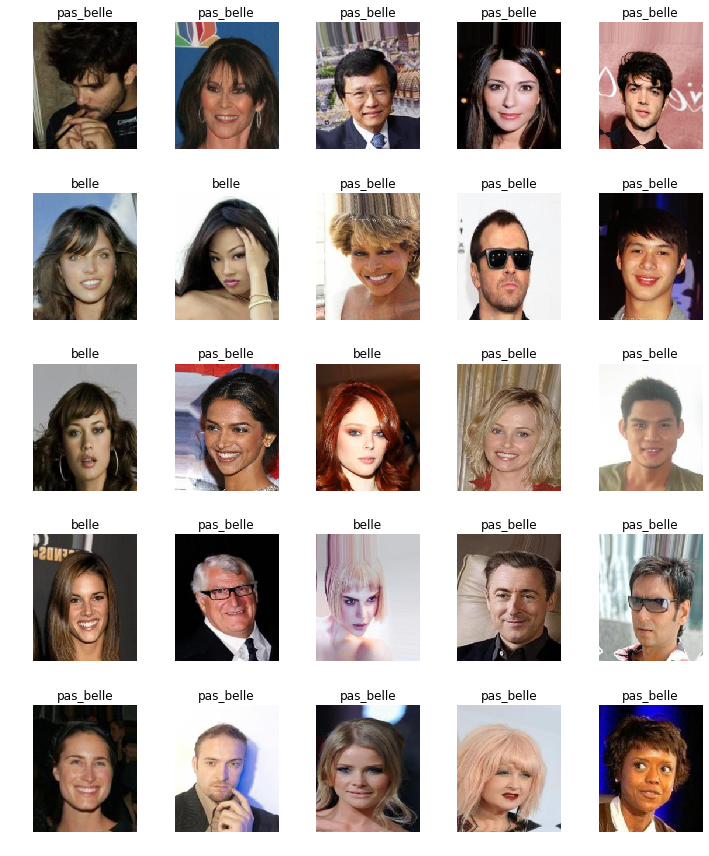

In [0]:
data.show_batch(rows=5, figsize=(10,12))

In [0]:
# print(data.classes)
# len(data.classes)
# data.c

['belle', 'pas_belle']


2

##Finetuning / training

In [0]:
# creating a learner
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.854994,0.506176,0.274510,00:06
1,0.751046,0.594663,0.274510,00:04
2,0.653756,0.586248,0.274510,00:04
3,0.597427,0.571209,0.303922,00:04


In [0]:
# learn.save('stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused()

[('pas_belle', 'belle', 19), ('belle', 'pas_belle', 12)]

## Find a good learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


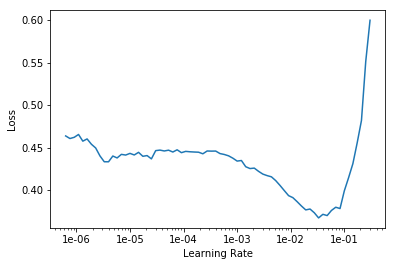

In [0]:
learn.lr_find()
learn.recorder.plot()

## One Cycle Policy

In [0]:
epoch=16
learn.unfreeze()
learn.fit_one_cycle(epoch, max_lr=slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.416728,0.553483,0.274510,00:05
1,0.380222,0.531901,0.254902,00:05
2,0.343804,0.621277,0.245098,00:05
3,0.310841,0.801272,0.215686,00:05
4,0.280874,0.972221,0.235294,00:05
5,0.258102,0.875190,0.196078,00:05
6,0.229612,0.933874,0.176471,00:05
7,0.209746,1.018392,0.186275,00:05
8,0.186090,0.964638,0.176471,00:05
9,0.167219,0.903310,0.196078,00:05


In [0]:
# learn.save('stage-2')
# learn.load('stage-2')

<font size="5">
    Once the model is trained, I tested it on a russian actress from siberia
</font> 

In [0]:
img1 = open_image(path + '1.jpg').resize((3, 218, 178))
img2 = open_image(path + '2.jpg').resize((3, 218, 178))
img3 = open_image(path + '3.jpg').resize((3, 218, 178))
img4 = open_image(path + '4.jpg').resize((3, 218, 178))
img5 = open_image(path + '5.jpg').resize((3, 218, 178))

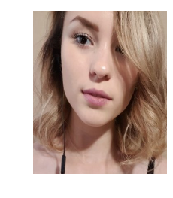

In [0]:
img2.show()

In [0]:
learn.predict(img2)

(Category belle, tensor(0), tensor([0.9956, 0.0044]))

#Using pytorch

In [0]:
import os
import torch
import math
from torch import optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import tqdm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Dataset and dataset transformations


In [0]:
class My_Dataset(Dataset):
    """dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(csv_file)
        self.labels = self.labels.sort_values(by='file_name')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        img_name = self.root_dir + self.labels.iloc[idx, 0]
        
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        
        # convert labels str into int for prediction
        # int will be automaticaly passed as a tensor of size batch by pytorch to calculate loss
        if label == 'belle':
            label = 1
        else:
            label = 0
            
        sample = {'image': image, 'label': label}

        if self.transform:
            sample['image'] = self.transform(image)

        return sample

##Setting paths for working with files from Google drive in Colab

In [0]:
path = './drive/My Drive/AI_Perso/'

face_dataset = My_Dataset(csv_file=path + 'labels.csv',
                          root_dir=path + 'img/')

##Setting transormations to work with my own images

In [0]:
composed = transforms.Compose([transforms.Resize(size=(218, 178)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225]) # imagenet_stats
                              ])

##Showing image

In [0]:
# a function to show the image calibrated
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    np.clip(inp, 0, 1, out=inp)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

##Inspecting the dataseet

torch.Size([3, 218, 178]) 1
torch.Size([3, 218, 178]) 1
torch.Size([3, 218, 178]) 0
torch.Size([3, 218, 178]) 0


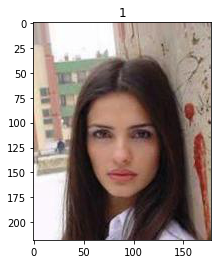

In [0]:
transformed_dataset = My_Dataset(csv_file=path + 'labels.csv',
                                 root_dir=path + 'img/',
                                 transform=composed)

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(sample['image'].size(), sample['label'])

    if i == 3:
        break
# trs = transforms.ToPILImage()
# img = trs(transformed_dataset.__getitem__(1)['image'])
# img
idx = 25
imshow(transformed_dataset.__getitem__(idx)['image'], title=transformed_dataset.__getitem__(idx)['label'])

## Split training/validation

In [0]:
# the way we split here does not really matter here, we split like 80/20 perc.
train_dataset = torch.utils.data.Subset(transformed_dataset,
                                        [e for e in range(0, int(len(transformed_dataset) * 0.8))])

valid_dataset = torch.utils.data.Subset(transformed_dataset,
                                        [e for e in range(int(len(transformed_dataset) * 0.8),
                                         len(transformed_dataset))])

##Verifying all the data

In [0]:
print(len(transformed_dataset))
print(len(train_dataset))
print(len(valid_dataset))

510
408
102


In [0]:
# testing the set of data
for i in range(0, 1):
    
    print("----trainset----")
    sample = train_dataset[i]
    print(sample['image'], sample['label'])
    print(type(sample['label']))
    print(sample['image'].size(), type(sample['image']))
    print(sample['image'].type())
    
    print("----validset----")
    sample = valid_dataset[i]
    print(sample['image'], sample['label'])
    print(sample['image'].size(), type(sample['image']))
    print(sample['image'].type())

----trainset----
tensor([[[ 2.2147,  2.2147,  2.2147,  ...,  2.1119,  2.2318,  2.2318],
         [ 2.2147,  2.2147,  2.2147,  ...,  2.1462,  2.2318,  2.2318],
         [ 2.2147,  2.2147,  2.2147,  ...,  2.1633,  2.2489,  2.2489],
         ...,
         [ 0.2796, -0.1314,  0.3823,  ..., -0.0287, -0.0287, -0.0287],
         [ 0.1083,  0.2453,  0.7248,  ..., -0.0972, -0.0972, -0.0972],
         [ 0.7591,  1.3755,  2.0777,  ..., -0.0972, -0.0629, -0.0629]],

        [[ 2.0084,  2.0084,  2.0084,  ...,  1.9209,  2.1310,  2.1310],
         [ 2.0084,  2.0084,  2.0084,  ...,  1.9559,  2.1310,  2.1310],
         [ 2.0084,  2.0084,  2.0084,  ...,  2.0084,  2.1485,  2.1485],
         ...,
         [-0.7402, -1.1954, -0.6702,  ..., -1.0728, -1.0553, -1.0553],
         [-0.9503, -0.8102, -0.3200,  ..., -1.1779, -1.1429, -1.1429],
         [-0.2850,  0.3452,  1.0630,  ..., -1.1779, -1.1604, -1.1604]],

        [[ 1.5768,  1.5768,  1.5768,  ...,  2.1171,  2.0648,  2.0648],
         [ 1.5768,  1.5768, 

##Setting batch size

In [0]:
bs=8

##Creating loaders and verifying the size

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs,
                        shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs,
                        shuffle=True, num_workers=4)

In [0]:
# next(iter(train_loader))

# printing batches
for i, data in enumerate(train_loader, 0):
        # get the inputs and labels
        in_data, label = data['image'], data['label']
        print(in_data.size(), label)
        if i == 3:
            break

torch.Size([8, 3, 218, 178]) tensor([0, 1, 0, 0, 0, 0, 0, 0])
torch.Size([8, 3, 218, 178]) tensor([0, 1, 0, 0, 0, 1, 1, 0])
torch.Size([8, 3, 218, 178]) tensor([0, 0, 0, 0, 0, 0, 1, 0])
torch.Size([8, 3, 218, 178]) tensor([0, 0, 0, 0, 0, 0, 0, 1])


##Creating the show batch function

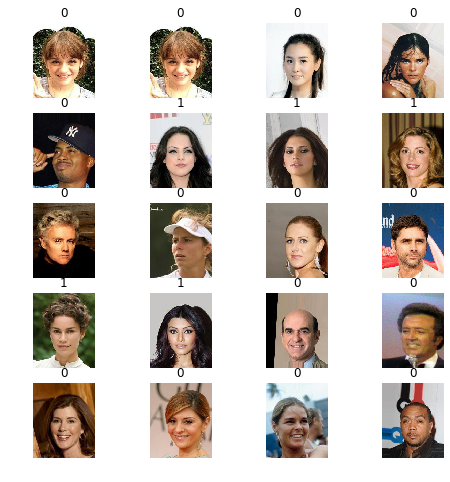

In [0]:
# a function using imshow to show a batch
def show_batch(columns = 4, rows = 5, figsize=(8,8), dataset=None):
    
    fig = plt.figure(figsize=figsize)
    
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        img_xy = np.random.randint(len(dataset))
        img = dataset[img_xy]['image']
        title = dataset[img_xy]['label']
        plt.axis('off')
        imshow(img, title)
        
show_batch(dataset=train_dataset)  

##Some tests, just a personnal reminder

In [0]:
# maniere d'eclater le modele, qui permet d'inserer des layers ou on veut

# vgg16 = models.vgg16_bn(pretrained=True)
# print(vgg16.parameters)
# for param in vgg16.parameters():
#     param.requires_grad = False
    
    
# features = list(vgg16.features.children())
# # avgpool = list(vgg16.avgpool.children()) this line is not Sequential, does not work
# avgpool = list(nn.Sequential(nn.AdaptiveAvgPool2d(output_size=(7, 7)))) # this works
# classifier = list(vgg16.avgpool.children())

# new_model = nn.Sequential(*features, *avgpool, *classifier)
# print(new_model.parameters)

In [0]:
# maniere plus simple / propre

# num_classes = 2
# model = models.vgg19(pretrained=True)
# print(model.parameters)
# for param in model.parameters():
#     param.requires_grad = False
    
#     # Replace the last fully-connected layer
#     # Parameters of newly constructed modules have requires_grad=True by default
# model.features[0] = nn.Linear(512, num_classes)
# model.classifier[4] = None
# model.fc = nn.Linear(512, 8)
# print(model.parameters)

# new_model = nn.Sequential(model.features, model.fc) # compiles but not sure if it works
# print(new_model.parameters)

In [0]:
# model = nn.Sequential(models.vgg19(True), YourModule())
# # Use it as usual
# out = model(input)

##Importing pretrained model

In [0]:
model = models.resnet34(pretrained=True)

# model[0] is resnet
# model[1] is softmax
# model = nn.Sequential(model, nn.Softmax(dim=1)) # to get a probability 

In [0]:
model.parameters

In [0]:
# freeze all the pretrained layers if needed
for param in model.parameters():
    param.requires_grad = False

In [0]:
# unfreeze all the pretrained layers if needed
for param in model.parameters():
    param.requires_grad = True

In [0]:
# class Identity(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#     def forward(self, x):
#         return x

In [0]:
# replace the last linear layer of resnet34
# the new layer is trainable by default
# model.fc = Identity

# model[0].fc = nn.Linear(in_features=512, out_features=2, bias=True)
model.fc = nn.Linear(in_features=512, out_features=2, bias=True)

In [0]:
# variant
# freeze all the layers if needed
for param in model.parameters():
    param.requires_grad = False

# train the last layer only
model[0].fc.weight.requires_grad = True
model[0].fc.bias.requires_grad = True

##Printing trainable parameters

In [0]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

fc.weight tensor([[ 0.0065,  0.0301,  0.0015,  ..., -0.0106,  0.0404,  0.0153],
        [ 0.0225, -0.0349,  0.0417,  ...,  0.0189,  0.0024, -0.0280]],
       device='cuda:0')
fc.bias tensor([ 0.0321, -0.0403], device='cuda:0')


In [0]:
# print(model.parameters)
print(model.modules)

##Setting criterion and optimizer

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

##Discriminative learning rate if needed

In [0]:
# add discriminative learning rate, personnal reminder
# optimizer = torch.optim.Adam([{'params': model.conv1.parameters()},
#                   {'params': model.bn1.parameters()},
#                   {'params': model.layer1.parameters()},
#                   {'params': model.layer2.parameters()},
#                   {'params': model.layer3.parameters()},
#                   {'params': model.layer4.parameters()},
#                   {'params': model.fc.parameters(), 'lr': 1e-3}
#                  ], lr=1e-7)

In [0]:
optimizer = optim.SGD(model.parameters(), lr=3e-2)

## Find a good learning rate

In [0]:
class CLR():
    """
    The method is described in paper : https://arxiv.org/abs/1506.01186 to find
    out optimum learning rate. The learning rate is increased from lower value
    to higher per iteration for some iterations till loss starts exploding.
    The learning rate one power lower than the one where loss is minimum
    is chosen as optimum learning rate for training.
    Args:
        train_loader The dataset loader of the training set.
        model        The model we want to find a good learning rate.
        optim        Optimizer used in training.
        bn           Total number of iterations used for this test run.
                     The learning rate increasing factor is calculated based on this 
                     iteration number.
        base_lr      The lower boundary for learning rate which will be used as
                     initial learning rate during test run. It is adviced to start from
                     small learning rate value like 1e-4.
                     Default value is 1e-5
        max_lr       The upper boundary for learning rate. This value defines amplitude
                     for learning rate increase(max_lr-base_lr). max_lr value may not be 
                     reached in test run as loss may explode before reaching max_lr.
                     It is adviced to use higher value like 10, 100.
                     Default value is 100.
        avg_beta     avg_beta is a parameter we get to pick between 0 and 1
                     This way the average losses will reduce the noise and give us a smoother graph
                     avg_beta is the parameter for the exponentially weighed loss
                     Default value is 0.98.
    """
    def __init__(self, train_loader, model, optim, bn, base_lr=1e-7, max_lr=10, avg_beta=0.98):
        self.train_loader = train_loader
        self.model = model.to(device)
        self.model.train()
        torch.save(self.model.state_dict(), './tmp')
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.avg_beta = avg_beta
        self.optim = optim
        self.bn = bn - 1
        ratio = self.max_lr/self.base_lr
        self.mult = ratio ** (1/self.bn)
        self.best_loss = 1e9
        self.iteration = 0
        self.lrs = []
        self.losses = []
    
    # update the lr
    def update_lr(self, lr):
        for g in self.optim.param_groups:
            g['lr'] = lr
            
    # find the lr
    def find_lr(self):
        t = tqdm.tqdm(self.train_loader, leave=False,
                      total=len(self.train_loader), position=0)
        running_loss = 0.
        
        for i, data in enumerate(t):

            var_ip, var_tg = data['image'].to(device), data['label'].to(device)
            output = self.model(var_ip)
            loss = criterion(output, var_tg)

            running_loss = self.avg_beta * running_loss + (1-self.avg_beta) * loss.item()
            smoothed_loss = running_loss / (1 - self.avg_beta**(i+1))
            t.set_postfix(loss=smoothed_loss)

            lr = self.calc_lr(smoothed_loss)
            if lr == -1 :
                break
            self.update_lr(lr)   

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        "Cleanup learn model weights disturbed during LRFinder exploration."
        self.model.load_state_dict(torch.load('./tmp'))
    # calculate the lr
    def calc_lr(self, loss):
        self.iteration +=1
        if math.isnan(loss) or loss > 4 * self.best_loss:
            return -1
        if loss < self.best_loss and self.iteration > 1:
            self.best_loss = loss
            
        mult = self.mult ** self.iteration
        lr = self.base_lr * mult
        
        self.lrs.append(lr)
        self.losses.append(loss)
        
        return lr
    # plot the result
    def plot(self, start=10, end=-5):
        plt.xlabel("Learning Rate (at log scale)")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.plot(self.lrs[start:end], self.losses[start:end])
        

In [0]:
clr = CLR(train_loader=train_loader, model=model, optim=optimizer, bn=len(train_loader))

In [0]:
clr.find_lr()

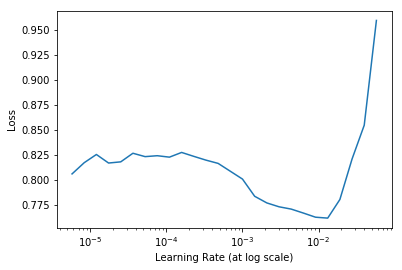

In [0]:
clr.plot()

##Setting the learning rate, according to the graphical results

In [0]:
lr = 5e-2
# optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-2)
optimizer = optim.SGD(model.parameters(), lr=lr)

In [0]:
# nan values during training...
# optimizer = optim.SGD([{'params': model.conv1.parameters()},
#                        {'params': model.bn1.parameters()},
#                        {'params': model.layer1.parameters()},
#                        {'params': model.layer2.parameters()},
#                        {'params': model.layer3.parameters()},
#                        {'params': model.layer4.parameters()},
#                        {'params': model.fc.parameters(), 'lr': lr}
#                       ], lr=1e-7)

##Save a checkpoint if needed

In [0]:
# def save_checkpoint(model, is_best, filename='checkpoint.pth'):
#     """Save checkpoint if a new best is achieved"""
#     if is_best:
#         torch.save(model.state_dict(), filename)  # save checkpoint
# #         print('checkpoint saved')
#     else:
#         print ("=> Validation Accuracy did not improve")

## One Cycle Policy

In [0]:
class OneCycle():
    """
    In paper (https://arxiv.org/pdf/1803.09820.pdf), author suggests to do one
    cycle during whole run with 2 steps of equal length. During first step,
    increase the learning rate from lower learning rate to higher learning rate.
    And in second step, decrease it from higher to lower learning rate.
    This is Cyclic learning rate policy. Author suggests one addition to this. -
    During last few hundred/thousand iterations of cycle reduce the 
    learning rate to 1/100th or 1/1000th of the lower learning rate.
    Also, Author suggests that reducing momentum when learning rate
    is increasing. So, we make one cycle of momentum also with learning rate -
    Decrease momentum when learning rate is increasing and increase momentum
    when learning rate is decreasing.
    Args:
        nb              Total number of iterations including all epochs.
        train_loader    The dataset loader of the training set.
        valid_loader    The dataset loader of the validation set.
        optim           Optimizer used in training.
        epoch           The number of epoch we want.
        model           The model we want to train.
        use_cycle       Boolean, if we train using 'one cycle' or not.
        max_lr          The optimum learning rate. This learning rate will be used as highest 
                        learning rate. The learning rate will fluctuate between max_lr to
                        max_lr/div and then (max_lr/div)/div.
        momentum_vals   The maximum and minimum momentum values between which momentum will
                        fluctuate during cycle.
                        Default values are (0.95, 0.85)
        prcnt           The percentage of cycle length for which we annihilate learning rate
                        way below the lower learnig rate.
                        The default value is 10
        div             The division factor used to get lower boundary of learning rate. This
                        will be used with max_lr value to decide lower learning rate boundary.
                        This value is also used to decide how much we annihilate the learning 
                        rate below lower learning rate.
                        The default value is 10.
        avg_beta        avg_beta is a parameter we get to pick between 0 and 1
                        This way the average losses will reduce the noise and give us a smoother graph
                        avg_beta is the parameter for the exponentially weighed loss
                        Default value is 0.98.
    """
    def __init__(self, nb, train_loader, valid_loader, optim, epoch, model, use_cycle,
                 max_lr, momentum_vals=(0.95, 0.85), prcnt= 10 , div=25, avg_beta=0.98):
        self.nb = nb
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.optim = optim
        self.epoch = epoch
        self.model = model.to(device)
        self.use_cycle = use_cycle
        self.div = div
        self.step_len =  int(self.nb * (1- prcnt/100)/2)
        self.high_lr = max_lr
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        self.prcnt = prcnt
        self.iteration = 0
        self.lrs = []
        self.moms = []
        self.avg_beta = avg_beta
        
    def calc(self):
        self.iteration += 1
        lr = self.calc_lr()
        mom = self.calc_mom()
        return (lr, mom)
    # update the momentum
    def update_mom(self, mom):
        for g in self.optim.param_groups:
            g['momentum'] = mom
    # update the learning rate
    def update_lr(self, lr):
        for g in self.optim.param_groups:
            g['lr'] = lr
    # calculate the lr
    def calc_lr(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        if self.iteration > 2 * self.step_len:
            ratio = (self.iteration - 2 * self.step_len) / (self.nb - 2 * self.step_len)
            lr = self.high_lr * ( 1 - 0.99 * ratio)/self.div
        elif self.iteration > self.step_len:
            ratio = 1- (self.iteration -self.step_len)/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        else :
            ratio = self.iteration/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        self.lrs.append(lr)
        return lr
    # calculate the momentum
    def calc_mom(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        if self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration - self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        self.moms.append(mom)
        return mom
    # defining the accuracy measurement
    def accuracy(self, output, target):
        _, predicted = torch.max(output, 1)
        total = len(target)
        correct = (predicted == target).sum()
        accuracy = 100 * correct / total
#         print (accuracy)
        return accuracy
    # defining the training and validation methods of the model
    def fit_one_cycle(self):
        print("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
        
        for i in range(self.epoch):
            '''training'''
#             model.train()
            best_acc = 1e-9
            trn_accs, trn_losses, train_stats = [], [], []
            running_loss = 0.
        
            for data in self.train_loader:
                var_ip, var_tg = data['image'].to(device), data['label'].to(device)

                if self.use_cycle:    
                    lr, mom = self.calc()
                    self.update_lr(lr)
                    self.update_mom(mom)

                output = self.model(var_ip)
                loss = criterion(output, var_tg)
#                 print(output)
                running_loss = self.avg_beta * running_loss + (1-self.avg_beta) *loss.item()
                smoothed_loss = running_loss / (1 - self.avg_beta**(i+1))

                trn_losses.append(smoothed_loss)

                # measure accuracy and record loss
                prec = self.accuracy(output.data, var_tg)
                trn_accs.append(prec)

                if prec > best_acc :
                    best_acc = prec
#                     save_checkpoint(self.model, True)

                # compute gradient and do SGD step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            '''validation'''
            self.model.eval()
            running_loss = 0.
            val_accs, val_losses = [], []    
            
            for data in self.valid_loader:
                
                var_ip, var_tg = data['image'].to(device), data['label'].to(device)

                output = self.model(var_ip)
                loss = criterion(output, var_tg)

                running_loss = self.avg_beta * running_loss + (1-self.avg_beta) *loss.item()
                smoothed_loss = running_loss / (1 - self.avg_beta**(i+1))

                # measure accuracy and record loss
                prec = self.accuracy(output.data, var_tg)

                val_losses.append(smoothed_loss)
                val_accs.append(prec)

            print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
                  .format(i+1, trn_losses[-1], val_losses[-1],
                          trn_accs[-1], val_accs[-1]))

##Setting the number of epoch we want for training

In [0]:
epoch=16
# optimizer

##Training

In [0]:
# creating object to train
onecycle = OneCycle(len(train_dataset) * epoch/bs,
                    train_loader=train_loader,
                    valid_loader=valid_loader,
                    use_cycle=True,
                    optim=optimizer,
                    model=model,
                    epoch=epoch,
                    max_lr=lr, prcnt=10,
                    momentum_vals=(0.95, 0.8))

In [0]:
onecycle.fit_one_cycle()

## Defining custom dataset for testing on other pics

In [0]:
# defining a new dataset to work with
class My_pics(Dataset):
    """dataset"""

    def __init__(self, path, transform=None):
        """
        Args:
            path (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.path = path
        self.transform = transform

    def __len__(self):
        return 5

    def __getitem__(self, idx):

        img_name = self.path + (str(idx+1)+'.jpg')
        
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

## Checking the data, taking the same picture as above in the Fast.ai model

torch.Size([3, 218, 178])
torch.Size([3, 218, 178])
torch.Size([3, 218, 178])
torch.Size([3, 218, 178])
torch.Size([3, 218, 178])


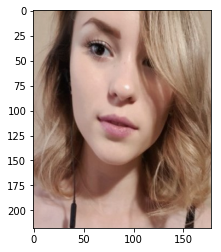

In [0]:
# verification
my_pics = My_pics(path=path, transform=composed)

for i in range(len(my_pics)):
    sample = my_pics[i]

    print(sample.size())

n = 1
imshow(my_pics.__getitem__(n))

In [0]:
#SOFTMAX ONLY FOR READABLE PROBABILITIES AFTER CROSSENTROPY

##Defining the prediction function

In [0]:
# tensor is the output of the model
def predict(tensor):
    if torch.argmax(tensor) == 0:
        print (tensor, ', pas_belle')
    else:
        print (tensor, ', belle')
    return

##Testing manually the model on a particular picture

In [0]:
# testing on the picture showed above
pics_loader = torch.utils.data.DataLoader(my_pics, batch_size=1, shuffle=False)
# prediction
model.eval()
liste = list(pics_loader)
prediction = model(liste[n].to(device))

predict(prediction)

tensor([[-8.0745,  8.3774]], device='cuda:0', grad_fn=<AddmmBackward>) , belle


#END